<h1 align="center"><font size="5"> Will the Loan Default? (Classification)</font></h1>

In this project we try to practice all the classification algorithms.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


### About dataset

This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it's one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
%matplotlib inline

### Load Data From CSV File

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing

Let’s see how many of each class is in our data set

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Let's plot some columns to underestand data better:

In [6]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

'conda' is not recognized as an internal or external command,
operable program or batch file.


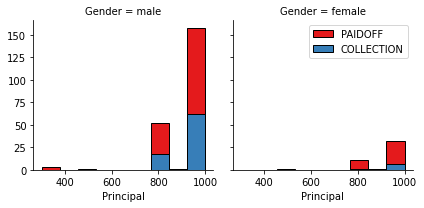

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

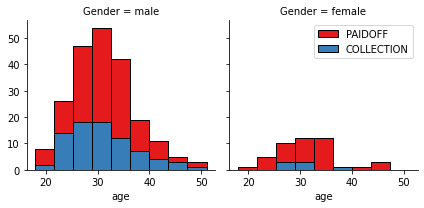

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan

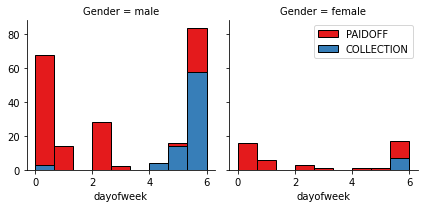

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Let's convert male to 0 and female to 1:

In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection

Let's define feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
# y=data_frame(['PAIDOFF'==1,'COLLECTION'==0])
df["loan_status"] = df["loan_status"].astype('category')
df.dtypes

df["loan_status_bin"] = df["loan_status"].cat.codes   #PAIDOFF=1 AND COLLECTION=0


In [18]:
y = df['loan_status_bin'].values
y[0:5]

array([1, 1, 1, 1, 1], dtype=int8)

## Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

Now, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
We the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


## (1) K Nearest Neighbor(KNN)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


Find the value of K.

Maximum accuracy:- 0.8 at K = 34


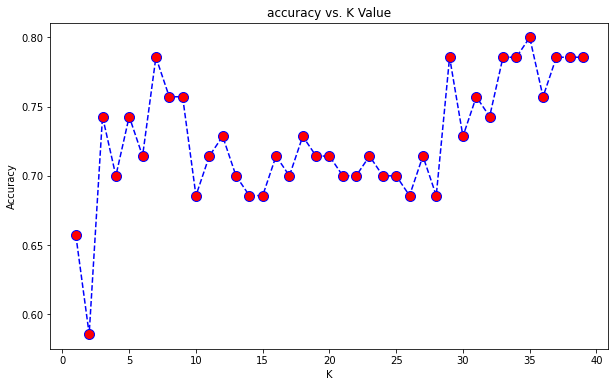

In [21]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

We got the accuracy of 0.8 at K=34.

In [22]:
k = 34
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(n_neighbors=34)

## (2) Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
loanTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [24]:
loanTree.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

## (3) Support Vector Machine

In [25]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X, y) 

SVC()

## (4) Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
LR

LogisticRegression(C=0.01, solver='liblinear')

# Model Evaluation using Test set

In [27]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation

In [28]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [29]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] =test_df['effective_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


In [30]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [31]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [32]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [33]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [34]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [35]:
Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [36]:
x = Feature1
x[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [37]:
test_df["loan_status"] = test_df["loan_status"].astype('category')
test_df.dtypes

test_df["loan_status_bin"] = test_df["loan_status"].cat.codes   #PAIDOFF=1 AND COLLECTION=0
Y = test_df['loan_status_bin'].values
Y[0:5]

array([1, 1, 1, 1, 1], dtype=int8)

In [38]:
x= preprocessing.StandardScaler().fit(x).transform(x)
x[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

##### (1) KNN

In [39]:
knnpred = neigh.predict(x)
knnpred[0:5]

array([1, 1, 1, 1, 1], dtype=int8)

In [40]:
# Accuracy
from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score(Y, knnpred))

Accuracy:  0.7962962962962963


In [41]:
# Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.80      0.29      0.42        14
           1       0.80      0.97      0.88        40

    accuracy                           0.80        54
   macro avg       0.80      0.63      0.65        54
weighted avg       0.80      0.80      0.76        54

Confusion matrix, without normalization
[[39  1]
 [10  4]]


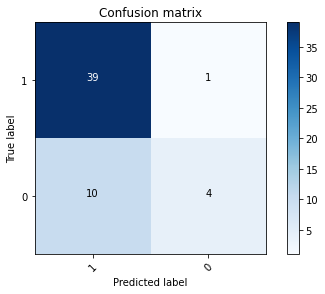

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, knnpred, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(Y,knnpred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0],normalize= False,  title='Confusion matrix')

In [43]:
# Jaccard Index
print("Jaccard Index:", jaccard_score(Y, knnpred,pos_label=1))

# F1_Score
print("f1_score:",f1_score(Y, knnpred))

Jaccard Index: 0.78
f1_score: 0.8764044943820225


#### (2) Decision Tree

In [44]:
treepred = loanTree.predict(x)
treepred[0:5]

array([1, 1, 1, 1, 1], dtype=int8)

In [45]:
# Accuracy
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(Y, treepred))

DecisionTrees's Accuracy:  0.7962962962962963


              precision    recall  f1-score   support

           0       0.71      0.36      0.48        14
           1       0.81      0.95      0.87        40

    accuracy                           0.80        54
   macro avg       0.76      0.65      0.67        54
weighted avg       0.78      0.80      0.77        54

Confusion matrix, without normalization
[[38  2]
 [ 9  5]]


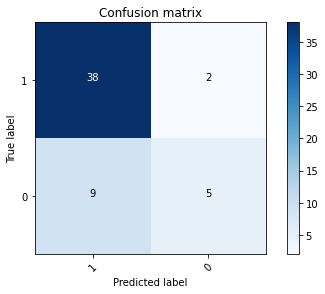

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, treepred, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(Y,treepred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0],normalize= False,  title='Confusion matrix')

In [47]:
# Jaccard Index
print("Jaccard Index:", jaccard_score(Y, treepred,pos_label=1))

# F1_Score
print("f1_score:",f1_score(Y, treepred))


Jaccard Index: 0.7755102040816326
f1_score: 0.8735632183908046


#### (3) Support Vector Machine

In [48]:
svmpred = clf.predict(x)
svmpred [0:5]

array([1, 1, 1, 1, 0], dtype=int8)

In [49]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(Y,svmpred))

Accuracy: 0.7222222222222222


In [50]:
# Jaccard Index
print("Jaccard Index:", jaccard_score(Y, svmpred,pos_label=1))

# F1_Score
print("f1_score:",f1_score(Y, svmpred))

Jaccard Index: 0.7222222222222222
f1_score: 0.8387096774193549


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      0.97      0.84        40

    accuracy                           0.72        54
   macro avg       0.37      0.49      0.42        54
weighted avg       0.55      0.72      0.62        54

Confusion matrix, without normalization
[[39  1]
 [14  0]]


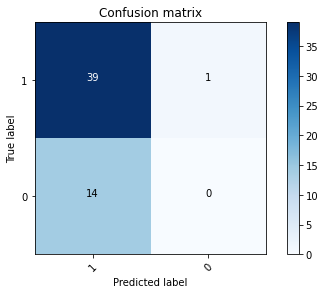

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, svmpred, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(Y, svmpred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0],normalize= False,  title='Confusion matrix')

#### (4) Logistic Regression

In [52]:
logpred = LR.predict(x)
print(logpred[0:5],"\n")

logpred_prob = LR.predict_proba(x)
print(logpred_prob[0:5])

[1 1 1 1 1] 

[[0.25 0.75]
 [0.4  0.6 ]
 [0.43 0.57]
 [0.47 0.53]
 [0.45 0.55]]


In [53]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(Y, logpred))

Accuracy: 0.7407407407407407


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[40  0]
 [14  0]]


C:\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


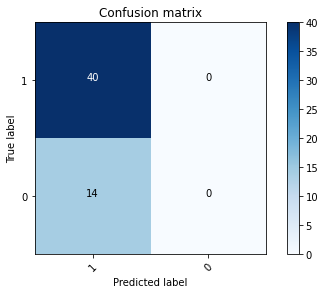

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, logpred, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(Y, logpred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0],normalize= False,  title='Confusion matrix')

In [55]:
# Jaccard Index
print("Jaccard Index:", jaccard_score(Y, logpred,pos_label=1))

# F1_Score
print("f1_score:",f1_score(Y, logpred))

# Log-Loss
print("log_loss:",log_loss(Y, logpred_prob))

Jaccard Index: 0.7407407407407407
f1_score: 0.851063829787234
log_loss: 0.5566084946309205


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                |     0.78  | 0.88        | NA      |
| Decision Tree      |   0.77     | 0.87        | NA      |
| SVM                |      0.72  | 0.84     | NA      |
| LogisticRegression | 0.74       | 0.85        | 0.56       |
